## Imports

In [44]:
from tensorflow.keras.datasets import mnist
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import gymnasium as gym
import random
import networkx as nx
import copy
from typing import Callable
import math

## Node

In [23]:
class Node:
    def __init__(self, id: int, type: bytearray, value: float = 0.0) -> None:
        self.id = id
        self.value = value
        self.type = type

    def __eq__(self, node: 'Node') -> bool:
        return self.id == node.id
    
    def __hash__(self) -> int:
        return hash(self.id)

    def relu(self, x: float) -> float:
        return np.maximum(0, x)

    def forward(self, connections) -> float:
        if self.type != 'input': 
            summ = sum(connection.weight * connection.source.value for connection in connections)
            self.value = self.relu(summ) if self.type != 'output' else summ

## Connection

In [24]:
class Connection:
    def __init__(self, source: 'Node', destination: 'Node', weight: int, innovation: int, enabled: bool=True) -> None:
        self.source = source
        self.destination = destination
        self.weight = weight
        self.innovation = innovation
        self.enabled = enabled

    def __eq__(self, innovation: int) -> bool:
        return self.innovation == innovation

## Innovation Buffer

In [25]:
class Innovations:
    def __init__(self) -> None:
        self.innovations = []

    def __repr__(self) -> str:
        return ", ".join([str(innovation) for innovation in self.innovations])
    
    def add(self, source: 'Node', destination: 'Node', weight: int = np.random.uniform(-1, 1), enabled: bool = True) -> 'Connection':
        if (source.id, destination.id) not in self.innovations:
            self.innovations.append((source.id, destination.id))
        return Connection(source, destination, weight, self.innovations.index((source.id, destination.id)), enabled)

## Genom

In [26]:
class Genom:
    def __init__(self, input_size: int, output_size: int, innovations: list, fitness_function: Callable[['Genom'], float]) -> None:
        self.nodes: list['Node'] = [Node(i, 'input') for i in range(input_size)] + [Node(i + input_size, 'output') for i in range(output_size)]
        self.connections: list['Connection'] = []
        self.fitness_function: Callable[['Genom'], float] = fitness_function

        for input_node in self.input_nodes:
            for output_node in self.output_nodes:
                self.connections.append(innovations.add(input_node, output_node))

    @property
    def input_nodes(self) -> list['Node']:
        return [node for node in self.nodes if node.type == 'input']
    
    @property
    def output_nodes(self) -> list['Node']:
        return [node for node in self.nodes if node.type == 'output']
    
    @property
    def random_node(self) -> 'Node':
        return self.nodes[np.random.randint(0, len(self.nodes))]
    
    @property
    def random_connection(self) -> 'Connection':
        return self.connections[np.random.randint(0, len(self.connections))]
    
    @property
    def graph(self) -> nx.Graph:
        G = nx.Graph()
        for node in self.nodes:
            G.add_node(node.id, color="red" if node.type == 'input' else "grey" if node.type == 'hidden' else "blue", layer=(0 if node.type == "input" else 1 if node.type == "hidden" else 2))

        for connection in self.connections:
            if connection.enabled:
                G.add_edge(connection.source.id, connection.destination.id, weight=format(connection.weight, '.2f'), color="black" if connection.enabled else "grey")

        return G
    
    @property
    def fitness(self) -> float:
        return self.fitness_function(self)
    
    def add_node(self, type: bytearray) -> 'Node':
        node = Node(len(self.nodes), type)
        self.nodes.append(node)
        return node

    def forward(self, input_data: list[any]) -> None:
        # Set input values
        for i, node in enumerate(self.input_nodes):
            node.value = input_data[i]

        # Forward propagation
        for node in self.nodes:
            connections: list[Connection] = [connection for connection in self.connections if connection.destination.id == node.id and connection.enabled]
            node.forward(connections)
        
        # Return output values
        return [node.value for node in self.output_nodes]
    
    def mutate(self, decrease_rate: int, innovations: 'Innovations', mutate_weight: float=0.8, mutate_connection: float=0.1, mutate_node: float=0.01) -> None:
        # Mutate weight 
        if np.random.uniform(0, 1) < (mutate_weight * decrease_rate):
            self.random_connection.weight = np.random.uniform(-1, 1)

        # Mutate connection by adding a new Connection between two random nodes
        if np.random.uniform(0, 1) < (mutate_connection * decrease_rate):
            node1 = self.random_node
            node2 = self.random_node
            while node1.type == node2.type:
                node1 = self.random_node
                node2 = self.random_node
            self.connections.append(innovations.add(node1, node2))
            
        # Mutate node by adding a new Node between two random nodes
        if np.random.uniform(0, 1) < (mutate_node * decrease_rate):
            connection = self.random_connection
            connection.enabled = False
            node = self.add_node('hidden')
            self.connections.append(innovations.add(connection.source, node, 1))
            self.connections.append(innovations.add(node, connection.destination, connection.weight))
            

# NEAT

In [49]:
class NEAT:
    def __init__(self, input_size: int, output_size: int, population_size: int, fitness_function: Callable[['Genom'], float]) -> None:
        self.population_size = population_size
        self.fitness_function = fitness_function
        self.innovations = Innovations()
        self.population = [Genom(input_size, output_size, self.innovations, fitness_function) for _ in range(population_size)]

    def reproduction(self, father: 'Genom', mother: 'Genom', decrease_rate: float):
        # create offspring genom 
        offspring = Genom(0, 0, self.innovations, self.fitness_function)
        # add distinct nodes from both parents
        offspring.nodes = copy.deepcopy(list(set(father.nodes + mother.nodes)))
        # add connections from father parent
        for connection in father.connections:
            offspring.connections.append(
                Connection(
                    offspring.nodes[connection.source.id], 
                    offspring.nodes[connection.destination.id], 
                    connection.weight, 
                    connection.innovation, 
                    connection.enabled
                )
            )
        # add connections from mother parent
        for connection in mother.connections:
            if connection.innovation in offspring.connections:
                # take mother connection with 50% chance
                if random.random() < 0.5:
                    for offspring_connection in offspring.connections:
                        if offspring_connection.innovation == connection.innovation:
                            offspring_connection.weight = connection.weight
                            offspring_connection.enabled = connection.enabled
                            break
            else:
                # distinct or excess connection from mother
                offspring.connections.append(
                    Connection(
                        offspring.nodes[connection.source.id], 
                        offspring.nodes[connection.destination.id], 
                        connection.weight, 
                        connection.innovation, 
                        connection.enabled
                    )
                )
            
        offspring.mutate(decrease_rate, self.innovations)
        self.population.append(offspring)

    def roulette_wheel_selection(self) -> 'Genom':
        # create list of fitnesses with exponential transformation to handle negative values
        fitnesses = [math.exp(genom.fitness) for genom in self.population]
        # calculate total fitness
        total_fitness = sum(fitnesses) 
        # create list of probabilities
        probabilities = [fitness / total_fitness for fitness in fitnesses]
        # return random genom based on probabilities
        return np.random.choice(self.population, p=probabilities)

    def fit(self, generations: int=10, selection_size: int=10, print: bool=False) -> 'Genom':
        for gen in trange(generations, desc ="Generations", ncols= 100):
            parents = []
            while len(parents) < selection_size:
                parents.append(self.roulette_wheel_selection())

            self.population = []
            while len(self.population) < self.population_size:
                self.reproduction(*random.sample(parents, 2), (1 - gen / generations))

            if print:
                display(clear=True)
                print(self.population[0].fitness)
                nx.draw(self.population[0].graph, with_labels=True)
                plt.draw()
                plt.pause(0.1)

        self.population.sort(key=lambda genom: genom.fitness, reverse=True)
        return self.population[0]

## Plotting

In [28]:
def plot_genom(genom: 'Genom', fitness_function: Callable[['Genom'], float]) -> None:
    # draw graph
    G = genom.graph
    node_color = [data["color"] for _, data in G.nodes(data=True)]
    edge_color = [data["color"] for _, _, data in G.edges(data=True)]
    pos = nx.multipartite_layout(G, subset_key="layer")
    nx.draw(G, pos, with_labels=True, node_color=node_color, edge_color=edge_color)
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=nx.get_edge_attributes(G, 'weight'),
        font_color='black'
    )

    # run best 100 times
    results = [fitness_function(genom) for _ in range(100)]
    # plot results 
    fig = plt.figure(figsize=(10, 5), clear=True)
    plt.plot(results, label="Reward")
    plt.ylim(ymin=min(results) - 1 if min(results) < 0 else 0)
    plt.xlim(xmin=0) 
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Average Reward per Episode")
    plt.legend()
    plt.close()
    display(fig, clear=True)

## Gymnasium Fitness for Classic Control

In [29]:
def gym_fitness(genom: 'Genom', problem: bytearray) -> float:
    # Create environment
    env = gym.make(problem)
    state, _ = env.reset()
    state = np.reshape(state, [1, env.observation_space.shape[0]])[0]
    total_reward = 0
    done = False

    while not done:
        # select action based on state
        action = np.argmax(genom.forward(state))

        # take action
        next_state, reward, terminated, truncated, _  = env.step(action)
        state = np.reshape(next_state, [1, env.observation_space.shape[0]])[0]
        done = terminated or truncated

        # update total reward
        total_reward += reward

    # close environment
    env.close()
    return total_reward

## NEAT CartPole Problem

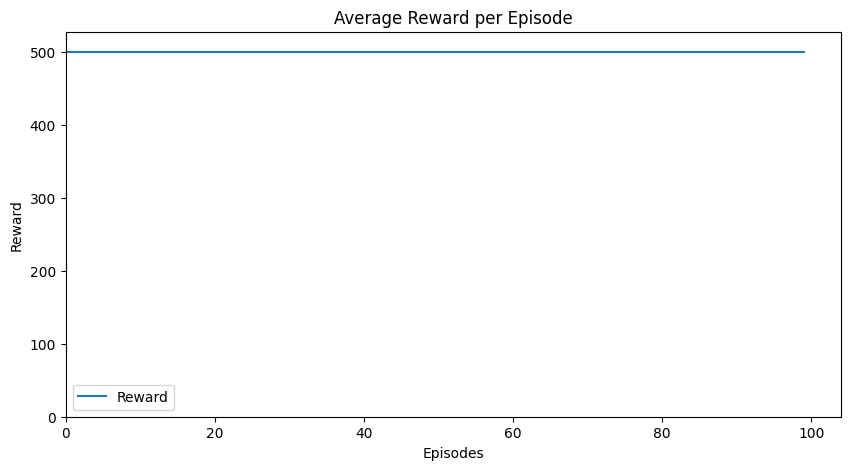

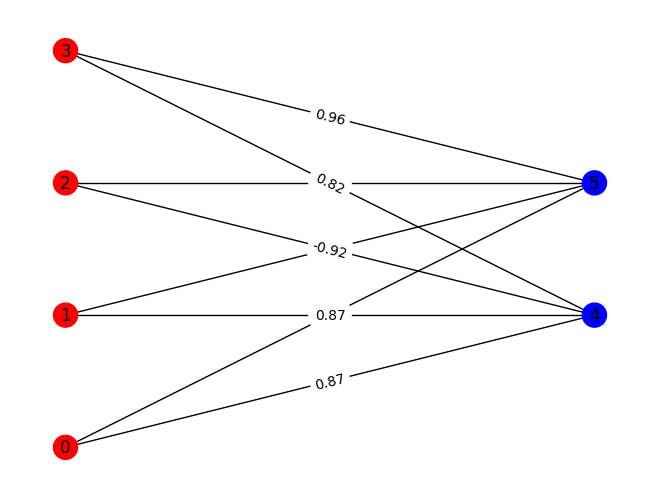

In [50]:
# Create Cartpole Fitness
def fitness(genom: 'Genom') -> float:
    return gym_fitness(genom, 'CartPole-v1')
# create NEAT Network
neat = NEAT(input_size=4, output_size=2, population_size=100, fitness_function=fitness)
# fit NEAT Network
best = neat.fit()
# plot best genom
plot_genom(best, fitness)


## NEAT Mountain Car

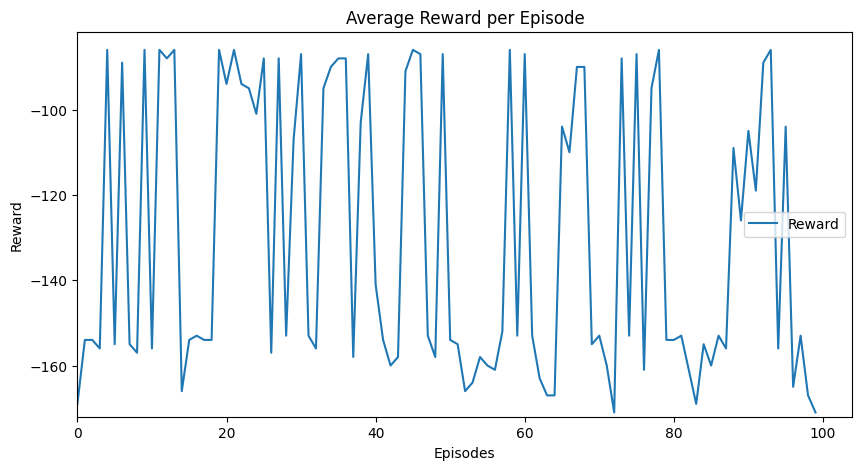

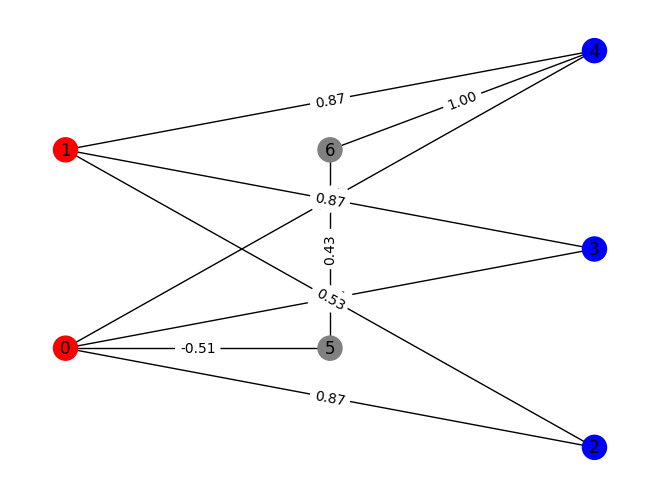

In [54]:
# Create MountainCar Fitness
def fitness(genom: 'Genom') -> float:
    return gym_fitness(genom, 'MountainCar-v0')
# create NEAT Network
neat = NEAT(input_size=2, output_size=3, population_size=200, fitness_function=fitness)
# fit NEAT Network
best = neat.fit(generations=10, selection_size=20)
# plot best genom
plot_genom(best, fitness)

## NEAT Acrobot

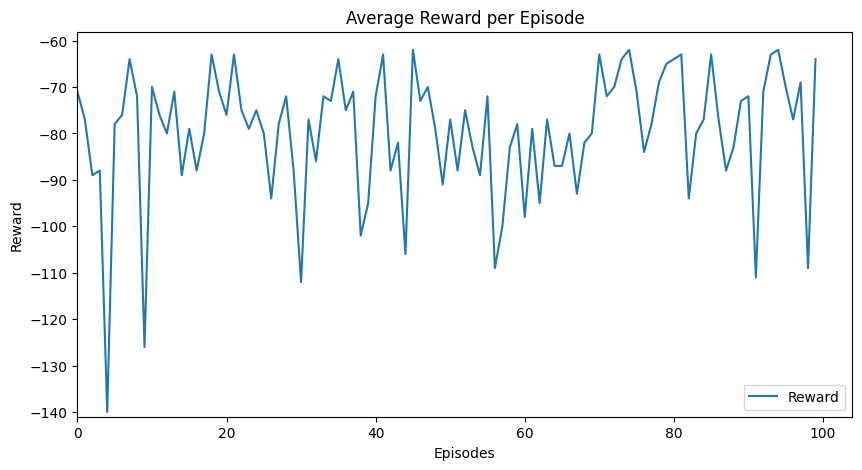

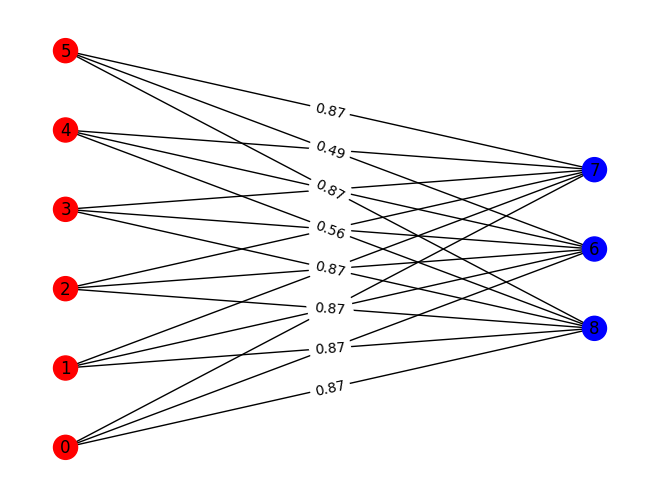

In [52]:
def fitness(genom: 'Genom') -> float:
    return gym_fitness(genom, 'Acrobot-v1')
# create NEAT Network
neat = NEAT(input_size=6, output_size=3, population_size=100, fitness_function=fitness)
# fit NEAT Network
best = neat.fit()
# plot best genom
plot_genom(best, fitness)

## NEAT MNIST

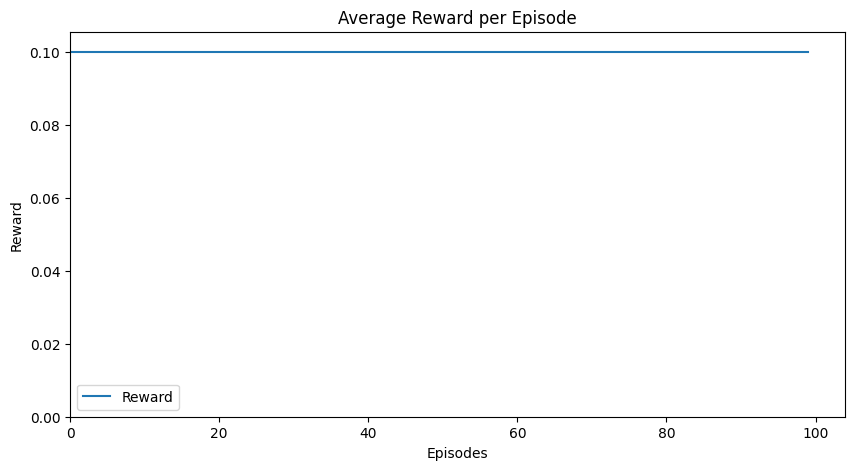

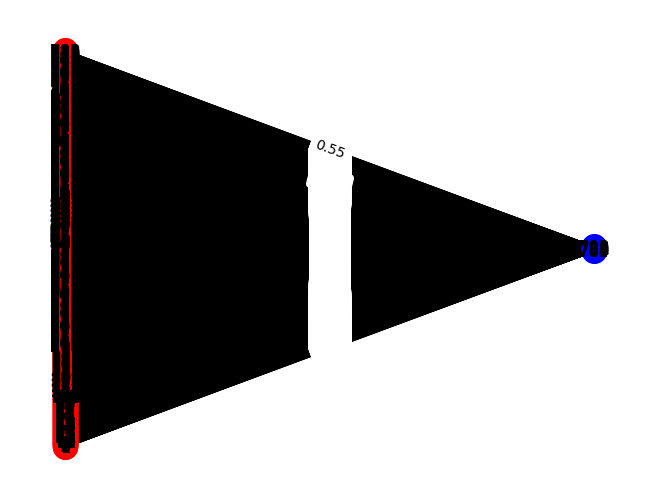

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Initialize a dictionary to hold the grouped data
grouped_train = {i: [] for i in range(10)}
grouped_test = {i: [] for i in range(10)}

# Group the images by their representing numbers
for img, label in zip(x_train, y_train):
    grouped_train[label].append(np.reshape(img, img.shape[0] * img.shape[1]))

for img, label in zip(x_test, y_test):
    grouped_test[label].append(np.reshape(img, img.shape[0] * img.shape[1]))

def accuracy(y_pred, y_true):
    return np.mean(np.argmax(y_pred, axis=0) == y_true)

def fitness_train(genom: 'Genom') -> float:
    total_accuracy = 0
    for i in range(10):
        total_accuracy += accuracy(genom.forward(grouped_train[i][random.randint(0, 5000)]), i)
    return total_accuracy / 10

def fitness_test(genom: 'Genom') -> float:
    total_accuracy = 0
    for i in range(10):
        total_accuracy += accuracy(genom.forward(grouped_test[i][random.randint(0, 500)]), i)
    return total_accuracy / 10

# create NEAT Network
neat = NEAT(input_size=784, output_size=10, population_size=2, fitness_function=fitness_train)
# fit NEAT Network
best = neat.fit(generations=1)
# plot best genom
plot_genom(best, fitness_test)